In [1]:
from typing import Callable, Dict, List, Tuple
GRAPH_NAME = "Max-cut qiskit (square)"
edges = {(0, 1): 1, (1, 2): 1, (2, 3): 1, (0, 3): 1}
num_nodes = 4

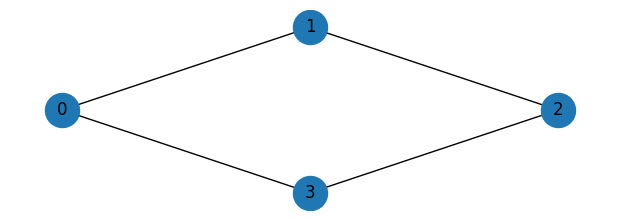

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Imprime un grafo dirigido pesado
# Entrada:
#   - graph_nodes: Lista de nodos del grafo
#   - graph_edges: Diccionario {edge: weight} donde edge es (n1, n2)
#   - layout: Para especificar la posición de los nodos
#
def print_graph(graph_nodes: List[int], graph_edges: Dict[Tuple[int, int], int],
                layout: Dict[int, List[int]]=None):
    G = nx.Graph()

    # Nodes
    G.add_nodes_from(graph_nodes)

    # Edges
    for pair, _ in graph_edges.items():
        G.add_edge(pair[0], pair[1])

    # Print graph
    if layout is None:
        layout = nx.spring_layout(G)

    plt.figure(3, figsize=(6, 2))
    nx.draw(G, layout, with_labels=True, node_size=600)
    #plt.savefig("../../latex/img/qiskit_grafo/qiskit_grafo.png")

print_graph(range(num_nodes), edges, layout={0: [-1, 0], 1: [0, 1],
                                             2: [1, 0],  3: [0, -1]})

In [3]:
# Función de coste binaria con valores {0, 1}
cost_function = "\
-(x_0*(1-x_1) + x_1*(1-x_0) + \
x_1*(1-x_2) + x_2*(1-x_1) + \
x_2*(1-x_3) + x_3*(1-x_2) + \
x_3*(1-x_0) + x_0*(1-x_3))"

# Evalúa una solución concreta según la función de coste para la versión QUBO
# Entrada:
#     - bits: Cadena con los valores de los qubits medidos
#             Orden: q_4 q_3 q_2 q_1 q_0
#
def eval_cost_function(bits: str) -> float:
    assert num_nodes == len(bits), "Error in cost_function: Length of bits"

    inv_bits = bits[::-1]  # Los qubits están en orden inverso

    param_dict = {}
    # Asignación entre x_ij -> q_n
    # Establecido por el orden de edges. Ej: x_12 -> q_2 (esto es, qubit nº2)
    for i in range(num_nodes):
        param_dict[f"x_{i}"] = int(inv_bits[i])

    return eval(cost_function, param_dict)

In [4]:
import itertools


# Obtener el mínimo resultado de una función binaria por fuerza bruta.
# Entrada:
#   - function: Función sobre la que operar
#   - num_bits: Número de bits de entrada
#
# Salida:
#   - Dict: ordenado por valor de menor a mayor con todos los resultados
#
def get_min_cost_function(function: Callable, num_bits: int) -> Dict[str, int]:
    results = {}
    for z in itertools.product(["0", "1"], repeat=num_bits):
        z = ''.join(z)
        results[z] = function(z)

    results = {k: v for k, v in sorted(results.items(), key=lambda x: x[1])}
    return results

get_min_cost_function(eval_cost_function, num_nodes)

{'0101': -4,
 '1010': -4,
 '0001': -2,
 '0010': -2,
 '0011': -2,
 '0100': -2,
 '0110': -2,
 '0111': -2,
 '1000': -2,
 '1001': -2,
 '1011': -2,
 '1100': -2,
 '1101': -2,
 '1110': -2,
 '0000': 0,
 '1111': 0}

In [5]:
from qiskit import QuantumCircuit


# Generación del circuito parametrizable ansatz
# Entrada:
#   - theta: Vectores alpha y beta concatenados (theta es de longitud 2*p)
#
# Salida:
#   - QuantumCircuit: Circuito resultante
#
def generate_qaoa_circuit(theta: List[float]) -> QuantumCircuit:
    assert len(theta) % 2 == 0, "Error in parameters (Beta, Gamma)"

    nqubits = num_nodes
    circuit = QuantumCircuit(nqubits)

    layers = int(len(theta) / 2)
    beta = theta[:layers]
    gamma = theta[layers:]

    # |v0>
    for i in range(nqubits):
        circuit.h(i)

    for p in range(layers):
        circuit.barrier()

        # Hp
        for q_idxs, _ in edges.items():
            circuit.rzz(gamma[p], q_idxs[0], q_idxs[1])

        circuit.barrier()

        # Hm
        for q_idx in range(nqubits):
            circuit.rx(beta[p] * 2, q_idx)

    return circuit

In [6]:
# Calcula el valor esperado dada la salida de una ejecución en Qiskit
# Entrada:
#   -counts: Diccionario {bits: probabilidad}
#
# Salida:
#   - Valor esperado
#
def compute_expectation(counts: Dict[str, int]) -> float:
    media = 0
    for bits, count in counts.items():
        cost = eval_cost_function(bits)
        media += cost * count

    return media

In [7]:
# QAOA - simulador Sampler - obtención de los parámetros óptimos
from qiskit.primitives import Sampler
from scipy.optimize import minimize

shots = 1024
sampler = Sampler(options={"shots": shots})

def execute_circuit(theta: List[float]) -> float:
    qc = generate_qaoa_circuit(theta)
    qc.measure_all()
    counts = sampler.run(qc).result().quasi_dists[0].binary_probabilities()
    return compute_expectation(counts)

num_layers = 2
theta_res = minimize(execute_circuit, [1.0, 1.0] * num_layers, method = "COBYLA")
theta_res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.98828125
       x: [ 1.007e+00  1.147e+00  8.558e-01  1.169e+00]
    nfev: 53
   maxcv: 0.0

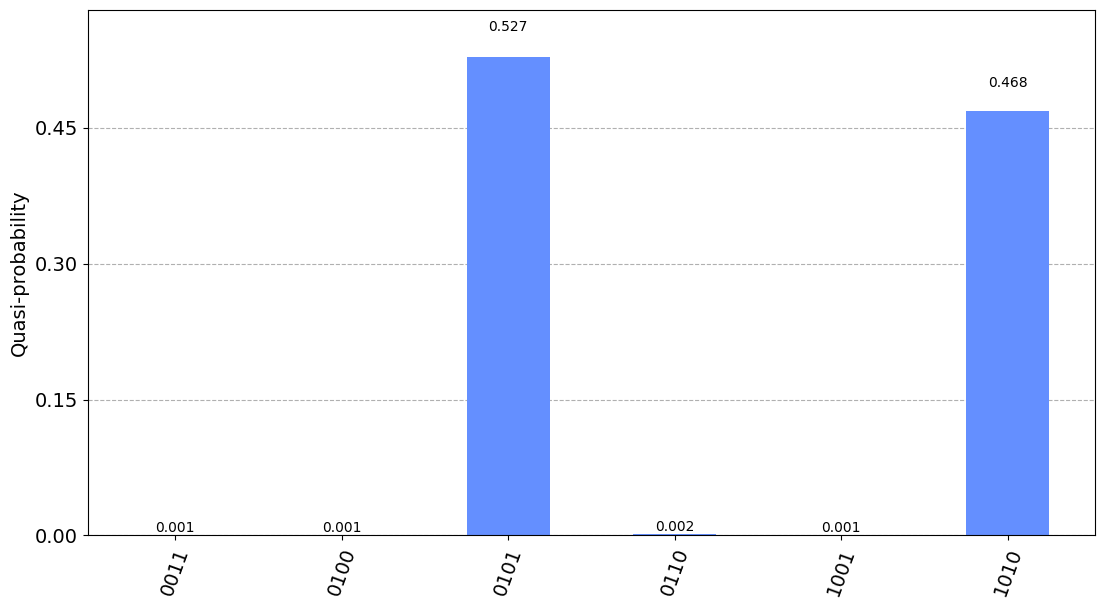

In [8]:
from qiskit.visualization import plot_histogram

shots = 1024
sampler = Sampler(options={"shots": shots})

qc = generate_qaoa_circuit(theta_res.x)
qc.measure_all()
counts = sampler.run(qc).result().quasi_dists[0].binary_probabilities()

plot_histogram(counts, figsize=(13, 6.83))

In [9]:
import numpy as np

def print_matrix(arr: np.array):
    if len(arr.shape) == 1:
        arr = np.array([arr.tolist()])
    arr = np.round(arr, 4)
    max_size = -1
    for row in arr:
        for el in row:
            curr_size = len(str(round(el.real, 4) + round(el.imag, 4) * 1.j))
            if curr_size > max_size:
                max_size = curr_size

    print('\\n'.join([''.join(['{:<{mx}} '.format(e, mx=max_size)
                               for e in row]).rstrip() for row in arr]))

In [10]:
# Experimento para visualizar los cambios de fase y amplitud en el estado
# Ej: Se pueden comentar las puertas Rx en generate_qaoa_circuit para observar
# como las probabilidades no se modifican
import qiskit.quantum_info as qi
from qiskit import Aer

backend = Aer.get_backend("aer_simulator")

qc = generate_qaoa_circuit([1.0, 1.0])
qc.save_statevector()
out_state = backend.run(qc).result().get_statevector()
# print_matrix(np.asarray(out_state))

prob_total = 0
for q_idx in range(num_nodes**2):
    ampl = out_state[q_idx]
    module = np.sqrt(ampl.real**2 + ampl.imag**2)
    prob = module**2
    prob_total += prob
    print(f"P({q_idx:04b}): {prob} {ampl}")

print(f"\nTOTAL: {prob_total}")
# qc.draw()

# print_matrix(np.asarray(qi.Operator(qc)))

P(0000): 0.05195354979808225 (-0.22472234154489285-0.03812373287943839j)
P(0001): 0.029753774139931632 (-0.16341090521590315+0.05523269137431881j)
P(0010): 0.029753774139931615 (-0.1634109052159031+0.0552326913743188j)
P(0011): 0.052519081722210356 (0.1293143675918928+0.18920062382698208j)
P(0100): 0.029753774139931615 (-0.1634109052159031+0.0552326913743188j)
P(0101): 0.22399319019777084 (-0.22472234154489285+0.41652498053340253j)
P(0110): 0.05251908172221034 (0.1293143675918928+0.18920062382698205j)
P(0111): 0.029753774139931577 (-0.16341090521590299+0.05523269137431877j)
P(1000): 0.029753774139931605 (-0.16341090521590307+0.0552326913743188j)
P(1001): 0.052519081722210356 (0.1293143675918928+0.18920062382698208j)
P(1010): 0.22399319019777078 (-0.22472234154489285+0.4165249805334025j)
P(1011): 0.029753774139931584 (-0.163410905215903+0.05523269137431877j)
P(1100): 0.05251908172221034 (0.1293143675918928+0.18920062382698205j)
P(1101): 0.029753774139931584 (-0.163410905215903+0.0552326

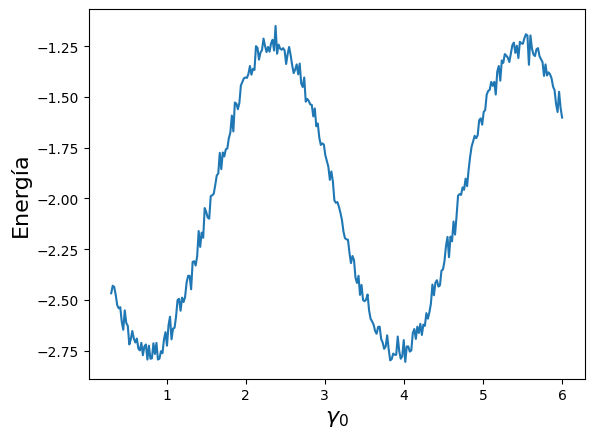

In [11]:
# Gamma function
import numpy as np
import matplotlib.pyplot as plt

def gamma_function():
    x = np.linspace(0.3, 6, 300)
    y = []
    beta = 1.0
    for gamma in x:
        y.append(execute_circuit([beta, gamma]))

    plt.xlabel(r"$\gamma_{0}$", fontsize=16)
    plt.ylabel("Energía", fontsize=16)
    plt.plot(x, y)
    # plt.savefig("../../latex/img/qiskit-grafo/gamma-fun-2d.png")
    plt.show()

gamma_function()

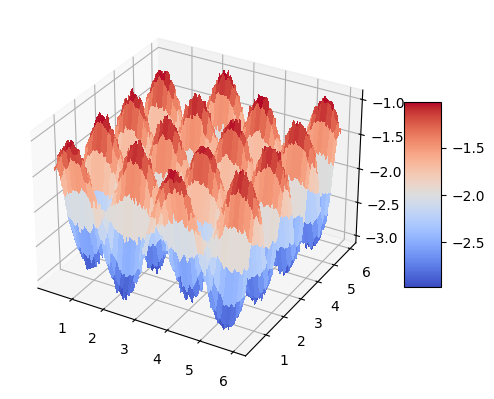

In [12]:
# 3D Gamma function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

def gamma_function_3d():
    beta = np.arange(0.3, 6, (6-0.3)/120)
    gamma = np.arange(0.3, 6, (6-0.3)/120)
    beta, gamma = np.meshgrid(beta, gamma)
    z = np.zeros([len(beta), len(beta)])

    for i in range(len(beta)):
        for j in range(len(beta)):
            z[i][j] = execute_circuit([beta[i][j], gamma[i][j]])

    fig = plt.figure()
    axis = plt.axes(projection='3d')
    figure = axis.plot_surface(gamma, beta, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(figure, shrink=0.5, aspect=5)
    # plt.savefig("../../latex/img/qiskit_grafo/gamma_fun_3d.png")
    plt.show()

gamma_function_3d()

In [ ]:
# Statistics

shots = 1024
sampler = Sampler(options={"shots": shots})

def max_global_statistics(num_layers=1, num_generations=100) -> Tuple[Dict[str, float],
                                                                      Dict[str, float]]:
    max_statistics = {}
    global_statistics = {}
    for iteration in range(0, num_generations):
        theta_res = minimize(execute_circuit, [1.0, 1.0] * num_layers, method = "COBYLA")
        qc = generate_qaoa_circuit(theta_res.x)
        qc.measure_all()
        counts = sampler.run(qc).result().quasi_dists[0].binary_probabilities()

        # Max statistics
        max_path = max(counts, key=counts.get)
        if max_path not in max_statistics:
            max_statistics[max_path] = 0
        max_statistics[max_path] += 1

        # Global statistics
        for (path, num_appearances) in counts.items():
            if path not in global_statistics:
                global_statistics[path] = 0
            global_statistics[path] += num_appearances

    for path in global_statistics:
        global_statistics[path] = global_statistics[path] / shots / num_generations  # Normalize

    for path in max_statistics:
        max_statistics[path] = max_statistics[path] / num_generations  # Normalize

    max_statistics = sorted(max_statistics.items(), key=lambda x: x[1], reverse=True)
    global_statistics = sorted(global_statistics.items(), key=lambda x: x[1], reverse=True)

    return max_statistics, global_statistics


print(GRAPH_NAME + ":\n")
interval_num_layers = (1, 3)
for p in range(interval_num_layers[0], interval_num_layers[1] + 1):
    max_st, global_st = max_global_statistics(num_layers=p, num_generations=100)
    print(f"Max statistics (p = {p}): ", str(max_st))
    print(f"Global statistics (p = {p}): ", str(global_st))
    print()